### Data cleaning
- Analyze the number of transactions with the property to find invalid id (-3 is invalid)
- Cleaning the values of categorical attributes (renaming by dictionary, mark unpopular as the OTHER group...)
- Convert the date feature types and generate different time features
- Convert float features and calculate correct amounts
- Calculate ranks (percentiles) of amounts and property size in the groups (for easy filtering outliers in the data)
- Geographical matching

In [1]:
t1 = dt.now()
print(t1)

2023-05-20 11:23:22.898382


#### Read

In [2]:
df1 = pd.read_csv('../data/rents.csv', sep = ';')
print(df1.shape)
df1[:3]

(5475131, 22)


,Ejari Contract Number,Registration Date,Start Date,End Date,Property ID,Version,Area,Contract Amount,Annual Amount,Is Free Hold?,Property Size (sq.m),Property Type,Property Sub Type,Number of Rooms,Usage,Nearest Metro,Nearest Mall,Nearest Landmark,Parking,No of Units,Master Project,Project
0,120210425000238,25/04/2021 09:36:31,13/04/2021 00:00:00,12/04/2026 00:00:00,1058329686,New,Dubai Investment Park Second,25000,5000,Free Hold,"7488,95",Building,Factory,NaN,Industrial,NaN,NaN,Expo 2020 Site,NaN,1,NaN,NaN
1,120210526001582,26/05/2021 12:12:22,01/06/2021 00:00:00,30/11/2025 00:00:00,99539298,New,Um Nahad Third,16000000,4000000,Free Hold,6792,Building,Building,NaN,Residential,NaN,NaN,NaN,NaN,1,NaN,NaN
2,120210526001913,26/05/2021 12:47:49,15/06/2021 00:00:00,14/12/2025 00:00:00,99539289,New,Um Nahad Third,16000000,4000000,Free Hold,"6481,94",Building,Building,NaN,Residential,NaN,NaN,NaN,NaN,1,NaN,NaN


In [3]:
n = df1.shape[0]
s = pd.concat([(df1.isnull().sum()).reset_index().T, df1.nunique().reset_index().T[1:], df1.dtypes.reset_index().T[1:]])
s.index = ['feat','nulls','unique','type']
s

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
feat,Ejari Contract Number,Registration Date,Start Date,End Date,Property ID,Version,Area,Contract Amount,Annual Amount,Is Free Hold?,Property Size (sq.m),Property Type,Property Sub Type,Number of Rooms,Usage,Nearest Metro,Nearest Mall,Nearest Landmark,Parking,No of Units,Master Project,Project
nulls,0,0,0,0,0,0,325,0,68,0,12491,0,40049,5285076,55172,562087,598919,346755,5306965,0,5474875,4680516
unique,2454744,4554167,6621,8544,1088523,2,216,193993,240600,2,45462,5,71,13,10,56,5,14,93,287,2,1100
type,int64,object,object,object,int64,object,object,object,object,object,object,object,object,float64,object,object,object,object,float64,int64,object,object


In [4]:
df1['Property ID'].value_counts()[:10]

-3         47614
 429756       95
 429753       86
 429762       85
 429747       84
 429771       83
 429786       79
 429774       76
 429750       75
 429792       74
Name: Property ID, dtype: int64

In [5]:
# invalid property id - replace as contract number (with minus)
f1 = df1['Property ID'] == -3
df1.loc[f1, 'Property ID'] = - df1.loc[f1, 'Ejari Contract Number']
df1 = df1.sort_values(['Property ID','Registration Date']).reset_index()
del df1['index']

#### Categorical features

In [6]:
# Property Type
repl1 = {
    'Villa': 'Building',
}
feat = 'Property Type'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)
df1[feat+ ' CLEAN'].value_counts()

Unit            4966083
Building         425216
Virtual Unit      47614
Land              36218
Name: Property Type CLEAN, dtype: int64

In [7]:
# Property Sub Type
repl1 = {
    'Hotel apartments': 'Hotel',
    'Complex Villas': 'Villa',
    'Villa addendum': 'Villa',
    'Warehouse complex': 'Warehouse',
    'Complex Warehouse': 'Warehouse',
    'Resturants Complex': 'Restaurant',
    'Kiosk': 'Shop',
    'Supermarket': 'Shop',
    'Supermarket, a multi-section': 'Shop',
    'Shopping Center': 'Shop',
    'Desk': 'Workshop',
    'Pertol station': 'Petrol station',
    'Staff Accommodation': 'Labor Camps',
    'Open Land': 'Open space',
    'Land Parking': 'Parking',
    'Building multi-storey parking': 'Parking',
    'Medical complex': 'Medical center',
    'Hospital': 'Medical center',
    'Clinic': 'Medical center',
    'Medical Store': 'Pharmacy',
    'GYM': 'Health club',
    'Spa': 'Health club',
    'swimming pool': 'Health club',
    'Sports Club': 'Health club',
    'Ladies Saloon': 'Health club',
    'Penthouse': 'Flat',
    'OPEN STORAGE SHED': 'Storage',
    'Hall': 'Mezzanine',
    'kitchen': 'Restaurant',
}
feat = 'Property Sub Type'
df1.loc[df1['Property Type'] == 'Land', feat] = 'Land'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')

df1[feat+ ' CLEAN'].value_counts()

Flat                              3158026
Shop                               605279
Office                             601007
Villa                              416961
Labor Camps                        382081
Studio                              76085
Warehouse                           75207
Hotel                               46961
Land                                36218
Showroom                            26197
Portacabin                           8346
Restaurant                           6383
Store                                4967
Building                             4957
Medical center                       4482
                                     3832
Workshop                             3059
Parking                              3026
Mezzanine                            2761
Open space                           2160
Arabian House                        1878
Health club                          1249
Factory                              1154
School                            

In [8]:
# Usage
repl1 = {
    'Agriculture': 'Commercial',
    # 'Industrial': 'Commercial',
    'Storage': 'Commercial',
    # 'Educational facility': 'Commercial',
    # 'Health Facility': 'Commercial',
    'Residential / Commercial': 'Commercial',
    'Industrial / Commercial': 'Commercial',
    'Tourist origin': 'Commercial',
}
feat = 'Usage'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

df1[feat+ ' CLEAN'].value_counts()

Residential             3976271
Commercial              1422699
                          55172
Industrial                18515
Health Facility            1366
Educational facility       1108
Name: Usage CLEAN, dtype: int64

In [9]:
# Nearest Landmark
repl1 = {
}
feat = 'Nearest Landmark'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

df1[feat+ ' CLEAN'].value_counts()

Dubai International Airport          2196636
Burj Khalifa                          653636
Burj Al Arab                          643798
Sports City Swimming Academy          483234
Downtown Dubai                        383981
                                      346755
Expo 2020 Site                        327120
IMG World Adventures                  187545
Motor City                            152464
Dubai Cycling Course                   38900
Al Makhtoum International Airport      35920
Dubai Parks and Resorts                13706
Global Village                          9639
Hamdan Sports Complex                   1620
Jabel Ali                                177
Name: Nearest Landmark CLEAN, dtype: int64

In [10]:
# Nearest Mall
repl1 = {
}
feat = 'Nearest Mall'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

df1[feat+ ' CLEAN'].value_counts()

Dubai Mall              2008775
City Centre Mirdif      1318449
                         598919
Mall of the Emirates     576465
Marina Mall              552565
Ibn-e-Battuta Mall       419958
Name: Nearest Mall CLEAN, dtype: int64

In [11]:
# Nearest Metro
repl1 = {
    'Jumeirah Beach Resdency': 'Jumeirah Beach Residency'
}
feat = 'Nearest Metro'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

df1[feat+ ' CLEAN'].value_counts().sort_index()

                                        562087
ADCB Metro Station                      147839
Abu Baker Al Siddique Metro Station      82304
Abu Hail Metro Station                   41095
Airport Free Zone                       138711
Airport Terminal 1 Metro Station          6609
Al Fahidi Metro Station                 188138
Al Ghubaiba Metro Station                84877
Al Jadaf Metro Station                   20234
Al Jafiliya Metro Station                32932
Al Nahda Metro Station                  123129
Al Qiyadah Metro Station                 56416
Al Qusais Metro Station                  73890
Al Ras Metro Station                     76019
Al Rigga Metro Station                   95036
Al Sufouh                                 8637
Baniyas Square Metro Station            227239
Buj Khalifa Dubai Mall Metro Station    128161
Burjuman Metro Station                  103803
Business Bay Metro Station              163797
Creek Metro Station                      36584
DANUBE Metro 

In [12]:
# Project
repl1 = {
}
feat = 'Project'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')

df1[feat+ ' CLEAN'].value_counts().sort_index()

                               4680516
014 TOWER                          243
23 MARINA                         1253
29 BOULEVARD                      3551
51@BUSINESS BAY                    884
                                ...   
ZAREEN RESIDENCE 3                 149
ZENITH TOWER A1                    799
ZENITH TOWER A2                    356
ZUMURUD DUBAI MARINA              1977
joya verde residences dubai        130
Name: Project CLEAN, Length: 845, dtype: int64

#### Dates

In [13]:
# dates features
feats1 = ['Registration Date', 'Start Date', 'End Date']
for f in feats1:
    df1[f] = pd.to_datetime(df1[f], errors = 'coerce', dayfirst = True)  
df1['reg_day']     = pd.to_datetime(df1['Registration Date'].astype(str).str[:10])
df1['reg_month']   = pd.to_datetime(df1['Registration Date'].astype(str).str[:7])
df1['reg_quarter'] = df1['Registration Date'].astype(str).str[:4] + 'Q' + pd.to_datetime(df1['Registration Date']).dt.quarter.astype(str)
df1['reg_year']    = df1['Registration Date'].astype(str).str[:4]

df1['st_day']     = pd.to_datetime(df1['Start Date'].astype(str).str[:10])
df1['st_month']   = pd.to_datetime(df1['Start Date'].astype(str).str[:7])
df1['st_quarter'] = df1['Start Date'].astype(str).str[:4] + 'Q' + pd.to_datetime(df1['Start Date']).dt.quarter.astype(str)
df1['st_year']    = df1['Start Date'].astype(str).str[:4]

(56, 37) (148, 37)


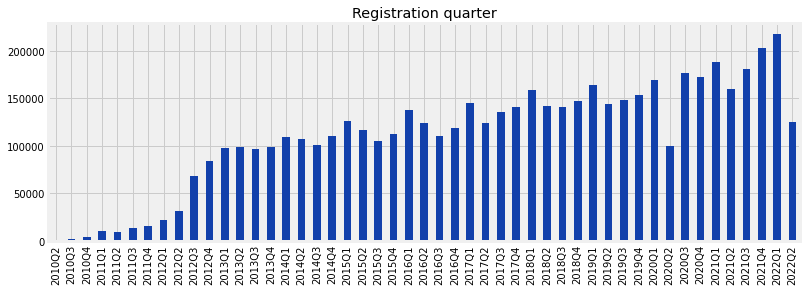

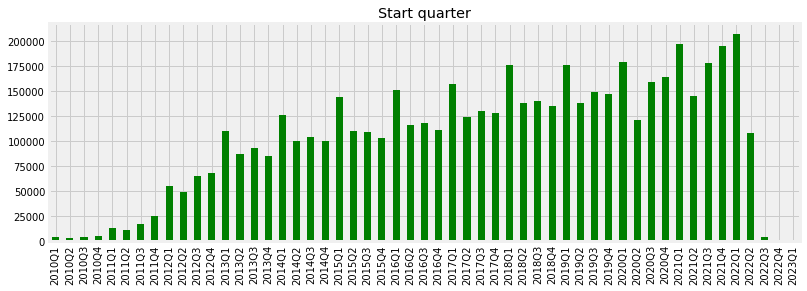

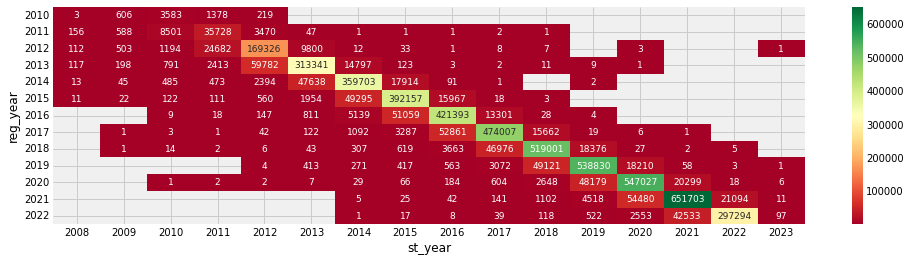

In [14]:
# reg and start time
color = '#1240AB'
df2 = df1.groupby(['reg_year','st_year']).size().unstack()
df3 = df2.loc[:,'2008':'2023']
print(df1[df1.st_year > '2023'].shape, df1[df1.st_year < '2008'].shape)

_, ax = plt.subplots(1,1, figsize = (12,4))
_ = df1.reg_quarter.value_counts().sort_index().plot(ax = ax, kind = 'bar', color = color, title = 'Registration quarter')

_, ax = plt.subplots(1,1, figsize = (12,4))
_ = df1.st_quarter.value_counts().sort_index().loc['2010Q1':'2023Q1'].plot(ax = ax, kind = 'bar', color = 'green', title = 'Start quarter')

_, ax = plt.subplots(figsize = (15,4))
_ = sns.heatmap(df3, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.0f', annot_kws={"size": 9})
plt.show()



#### Float features

In [15]:
# amounts
feat = 'Contract Amount'
df1[feat] = df1[feat].map(lambda x: float(str(x).replace(',','.')))
df1.loc[df1[feat] < 1, feat] = np.nan

feat = 'Annual Amount'
df1[feat] = df1[feat].map(lambda x: float(str(x).replace(',','.')))
df1.loc[df1[feat] < 1, feat] = np.nan

df1['Contract Years'] = df1['Contract Amount'] / df1['Annual Amount']
df1['Annual Amount unit'] = df1['Annual Amount'] / df1['No of Units']

# calculate price per sq.m
feat = 'Property Size (sq.m)'
df1[feat] = df1[feat].map(lambda x: float(str(x).replace(',','.')))
df1.loc[df1[feat] < 1, feat] = np.nan
df1['Price per sq.m'] = df1['Annual Amount unit'] / df1['Property Size (sq.m)']

In [16]:
# logarithm features
feats_num = ['Annual Amount unit','Property Size (sq.m)','Price per sq.m']
for feat in feats_num:
    df1[feat + ' LOG'] = df1[feat].map(np.log)

In [17]:
# Calculate ranks (percentiles) of amounts and property size by the cleaned Property Type (For easy filtering outliers)
feats_gr = ['Property Type CLEAN','reg_year']
for feat in feats_num:
    df1[feat + ' RANK'] = df1.groupby(feats_gr)[feat].transform(lambda x: x.rank(pct = True))

In [18]:
# flags    
df1['new_version'] = df1['Version'].map({'New': 1}).fillna(0).astype(int)
df1['free_hold']   = df1['Is Free Hold?'].map({'Free Hold': 1}).fillna(0).astype(int)

# unused
feats_drop = ['Number of Rooms','Parking','Master Project','Version','Is Free Hold?']
for f in feats_drop:
    del df1[f]

#### Geographical matching
- get one table with polygons by regions and sectors, show the borders
- create table with unique regions presented in the data
- create dictionaries to replace the names of the regions like it is in the shape file
- merge with polygons and write to file

(222, 3)
(222, 4)
222


,sector,geometry1,region,geometry2
0,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",Abu Hail,"POLYGON ((55.32696 25.27903, 55.32659 25.27963..."
1,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",Al Baraha,"POLYGON ((55.32234 25.28839, 55.32465 25.28369..."
2,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",Al Buteen,"POLYGON ((55.30154 25.26731, 55.29993 25.26727..."
3,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",Al Corniche,"POLYGON ((55.29571 25.27332, 55.29556 25.27379..."
4,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",Al Dhagaya,"POLYGON ((55.30041 25.27093, 55.30000 25.27087..."


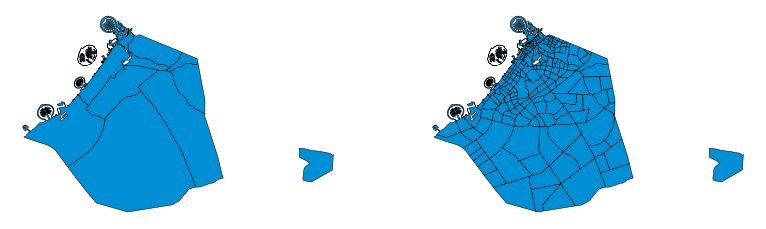

In [19]:
# get one table with polygons by regions and sectors, show the borders
import geopandas as gpd

df_area1 = gpd.read_file('../data/geo/gadm/gadm41_ARE_2.shp')
feats_used = ['NAME_2','geometry']
df_area1 = df_area1[df_area1.NAME_1 == 'Dubai'][feats_used].rename(columns = {'geometry': 'geometry1'})

df_area2 = gpd.read_file('../data/geo/gadm/gadm41_ARE_3.shp')
feats_used = ['NAME_2','NAME_3','geometry']
df_area2 = df_area2[df_area2.NAME_1 == 'Dubai'][feats_used].rename(columns = {'geometry': 'geometry2'})

df_area = df_area1.merge(df_area2).rename(columns = {'NAME_2':'sector','NAME_3': 'region'})
print(df_area2.shape)
print(df_area.shape)
print(df_area.region.nunique())

repl1 = {
    'Jebel Ali Industrial First': 'Jebel Ali Industrial Area First',
    'Jebel Ali Industrial Second': 'Jebel Ali Industrial Area Second',
    'Jebel Ali Industrial Third': 'Jebel Ali Industrial Area Third',
}
df_area['sector'] = df_area['sector'].map(lambda x: int(x.split(' ')[1]))
df_area['region'] = df_area['region'].map(lambda x: x if x not in repl1 else repl1[x])
repl2 = {
    'First': '1',
    'Second': '2',
    'Third': '3',
    'Fourth': '4',
    'Fifth': '5',
    'Sixth': '6',
    'Firs': '1',
    'Seco': '2',
    'Thir': '3',
    'Thrid': '3',
    'One': '1',
    'Two': '2',
    'Three': '3',
    'Four': '4',
    'Five': '5',
    'Six': '6',
}
def fun_repl2(x):
    for k,v in repl2.items():
        x = x.replace(k,v)
    return x.strip()
df_area['region'] = df_area['region'].map(fun_repl2)
display(df_area[:5])

_,ax = plt.subplots(1,2, figsize = (12,6))
_ = gpd.GeoDataFrame(df_area1).rename(columns = {'geometry1':'geometry'}).plot(
    ax = ax[0], edgecolor="black",
)
_ = _.axis('off')

_ = gpd.GeoDataFrame(df_area2).rename(columns = {'geometry2':'geometry'}).plot(
    ax = ax[1], edgecolor="black",
)
_ = _.axis('off')

In [20]:
# create table with unique regions presented in the data
df2 = df1.groupby(['Area']).size().reset_index().rename(columns = {0:'cnt'})
df2['cnt_log'] = df2['cnt'].map(np.log)

df2['region'] = df2.Area.str.strip()#.capitalize()
df2['region'] = df2['region'].map(fun_repl2)

repl3 = {
    'Industrial': 'Industrial Area',
    'Al Aweer': 'Al Awir',
    'Al Barshaa': 'Al Barsha', 
    'Al Eyas': 'Al Ayas',
    "Al Faga'A": "Al Fagaa'",
    'Al Garhoud': 'Al Gharoud',
    'Al Goze': 'Al Quoz',
    'Al Khabeesi': 'Al Khabisi',
    'Al Lusaily': 'El Lesaily',
    'Al Mamzer': 'Al Mamzar',
    'Al Mararr': 'Al Murar',
    'Al Marmoom': 'Al Marmoon',
    'Al Merkadh': 'Al Merkad',
    'Al Nahda': 'Al Nadha',
    'Al Rega': 'Al Rigga',
    'Al Saffa': 'Al Safa',
    'Al Suq Al Kabeer': 'Al Souq Al Kabeer',
    'Al Thanayah': 'Al Tanyah',
    'Al Thanyah': 'Al Tanyah',
    'Al Ttay': 'Al Tay',
    'Al Warqa': "Al Warqa'a",
    'Al Warsan': 'Warsan',
    'Al Yelayiss': 'Al Yalayis',
    'Bukadra': 'Bu Kadra',
    'Cornich Deira': 'Corniche Deira',
    'Dubai International Airport': 'Dubai airport',
    'Hadaeq Sheikh Mohammed Bin Rashid': 'Hadaeq Sheikh Mohammed Bin Rashi',
    'Jabal Ali': 'Jebel Ali',
    'Jumeirah': 'Jumeira',
    'Madinat Dubai Almelaheyah': 'Madinat Dubai Al Melaheyah',
    "Me'Aisem": "Me'aisem",
    'Nad Al Shiba': 'Nad Al Shibba',
    'Oud Al Muteena': 'Oud Al Muteen',
    'Palm Deira': 'Palm Deira (Under Construction)',
    'Rega Al Buteen': 'Rigga Al Buteen',
    'Um Al Sheif': 'Umm Al Sheif',
    'Um Hurair': 'Umm Hurair',
    'Um Nahad': 'Umm Nahad',
    'Um Ramool': 'Umm Ramool',
    'Um Suqaim': 'Umm Suqaim',
    'Wadi Al Amardi': 'Wadi Alamradi',
    'Zaabeel': "Za'abeel",
    'Al Safouh':'Al Sufouh',
    'Al-Cornich': 'Al Corniche',
    'Oud Almuteena': 'Oud Al Muteen',
}
def fun_repl3(x):
    for k,v in repl3.items():
        x = x.replace(k,v)
    return x.strip()
df2['region'] = df2['region'].map(fun_repl3)

repl4 = {
    'Nad Al Shibba': 'Nad Al Shibba 1',
    'Al Hebiah 6': 'Al Hebiah 5',
    'Al Qoaz': 'Al Qoaz 1',
    'Al Qusais': 'Al Qusais 1',
    'Al Ruwayyah': 'Al Rowaiyah 1',
    'Al Yufrah 3':'Al Yufrah 2',
    'Eyal Nasser':'Ayal Nasir',
    'Island 2':'Jumeira Island 2 (Daria Island',
    'Jebel Ali':'Jebel Ali 1',
    'Lehbab':'Lehbab 1',
    'Mankhool':'Al Mankhool',
    'Mirdif':"Al Warqa'a 1",
    'Muragab':'Margab',
    'Palm Jumeira':'Jumeira Island 1',
    'Shandagha':'Al Shandaga',
    'Business Bay': 'Jumeira 1',
}
df2['region'] = df2['region'].map(lambda x: x if x not in repl4 else repl4[x])
df2 = df2.sort_values('region')
print(df2.shape)
print(df2.region.nunique())
df2[:3]

(216, 4)
207


,Area,cnt,cnt_log,region
0,Abu Hail,10326,9.24,Abu Hail
1,Al Asbaq,2,0.69,Al Asbaq
2,Al Aweer First,2077,7.64,Al Awir 1


In [21]:
# merge with polygons
df3 = df2.merge(df_area, how = 'left')
print(df3.cnt.sum(), df3.shape)
df3[:3]

5474806 (216, 7)


,Area,cnt,cnt_log,region,sector,geometry1,geometry2
0,Abu Hail,10326,9.24,Abu Hail,1.00,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...","POLYGON ((55.32696 25.27903, 55.32659 25.27963..."
1,Al Asbaq,2,0.69,Al Asbaq,NaN,None,None
2,Al Aweer First,2077,7.64,Al Awir 1,6.00,"MULTIPOLYGON (((55.24958 24.99299, 55.24823 24...","POLYGON ((55.53066 25.18974, 55.53482 25.19299..."


In [22]:
# matched
df4 = df3[~df3.geometry1.isnull()]
df4['sector'] = df4['sector'].astype(int)

print(df4.cnt.sum(), df4.shape)
df4[:3]

5474255 (201, 7)


,Area,cnt,cnt_log,region,sector,geometry1,geometry2
0,Abu Hail,10326,9.24,Abu Hail,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...","POLYGON ((55.32696 25.27903, 55.32659 25.27963..."
2,Al Aweer First,2077,7.64,Al Awir 1,6,"MULTIPOLYGON (((55.24958 24.99299, 55.24823 24...","POLYGON ((55.53066 25.18974, 55.53482 25.19299..."
3,Al Aweer Second,1193,7.08,Al Awir 2,7,"POLYGON ((55.66167 25.00837, 55.66156 24.99897...","POLYGON ((55.51106 25.16164, 55.51219 25.16243..."


In [23]:
# unmatched
df5 = df3[df3.geometry1.isnull()]
print(df5.cnt.sum(), df5.shape)
df5

551 (15, 7)


,Area,cnt,cnt_log,region,sector,geometry1,geometry2
1,Al Asbaq,2,0.69,Al Asbaq,NaN,None,None
51,Al Qoaz,146,4.98,Al Qoaz 1,NaN,None,None
106,Al-Murar Qadeem,1,0.00,Al-Murar Qadeem,NaN,None,None
107,Al-Mustashfa West,1,0.00,Al-Mustashfa West,NaN,None,None
108,Al-Raulah,16,2.77,Al-Raulah,NaN,None,None
111,Bur Dubai,283,5.65,Bur Dubai,NaN,None,None
155,Mushrif,14,2.64,Mushrif,NaN,None,None
171,Palm Jabal Ali,1,0.00,Palm Jebel Ali,NaN,None,None
178,Saih Aldahal,1,0.00,Saih Aldahal,NaN,None,None
183,Shandagha East,1,0.00,Shandagha East,NaN,None,None


#### Save to files

In [24]:
# merge with main dataset
df1 = df1.merge(df4[['Area','region','sector']], on = 'Area', how = 'left')

In [25]:
# save geo matchings
df4.to_pickle('../data/df_rents_geo.pkl')

In [26]:
# label encoder of categorical feats by their popularity
feats_cat = [
 'region',
 'Project CLEAN',
 'Nearest Metro CLEAN',
 'Nearest Mall CLEAN',
 'Nearest Landmark CLEAN',
 'Property Type CLEAN',
 'Property Sub Type CLEAN',
 'Usage CLEAN',
] 
for f in feats_cat:
    repl = df1[f].fillna('').value_counts()
    repl.iloc[:] = range(len(repl))
    repl = repl.to_dict()
    df1[f + ' LABEL'] = df1[f].fillna('').map(repl)

In [27]:
# save to file
df1.to_pickle('../data/df_rents.pkl')
print(df1.shape)
df1[:3]

(5475131, 53)


,Ejari Contract Number,Registration Date,Start Date,End Date,Property ID,Area,Contract Amount,Annual Amount,Property Size (sq.m),Property Type,Property Sub Type,Usage,Nearest Metro,Nearest Mall,Nearest Landmark,No of Units,Project,Property Type CLEAN,Property Sub Type CLEAN,Usage CLEAN,Nearest Landmark CLEAN,Nearest Mall CLEAN,Nearest Metro CLEAN,Project CLEAN,reg_day,reg_month,reg_quarter,reg_year,st_day,st_month,st_quarter,st_year,Contract Years,Annual Amount unit,Price per sq.m,Annual Amount unit LOG,Property Size (sq.m) LOG,Price per sq.m LOG,Annual Amount unit RANK,Property Size (sq.m) RANK,Price per sq.m RANK,new_version,free_hold,region,sector,region LABEL,Project CLEAN LABEL,Nearest Metro CLEAN LABEL,Nearest Mall CLEAN LABEL,Nearest Landmark CLEAN LABEL,Property Type CLEAN LABEL,Property Sub Type CLEAN LABEL,Usage CLEAN LABEL
0,120220603001774,2022-06-03 12:15:42,2022-06-03,2023-06-02,-120220603001774,Dubai Investment Park First,"6,500.00","6,500.00",10.00,Virtual Unit,Office,Commercial,DANUBE Metro Station,Ibn-e-Battuta Mall,Expo 2020 Site,1,NaN,Virtual Unit,Office,Commercial,Expo 2020 Site,Ibn-e-Battuta Mall,DANUBE Metro Station,,2022-06-03,2022-06-01,2022Q2,2022,2022-06-03,2022-06-01,2022Q2,2022,1.00,"6,500.00",650.00,8.78,2.30,6.48,0.05,0.31,0.09,1,1,Dubai Investment Park 1,5.00,18,0,9,5,6,2,2,1
1,120220603001738,2022-06-03 12:11:13,2022-06-03,2023-06-02,-120220603001738,Dubai Investment Park First,"7,500.00","7,500.00",10.00,Virtual Unit,Office,Commercial,DANUBE Metro Station,Ibn-e-Battuta Mall,Expo 2020 Site,1,NaN,Virtual Unit,Office,Commercial,Expo 2020 Site,Ibn-e-Battuta Mall,DANUBE Metro Station,,2022-06-03,2022-06-01,2022Q2,2022,2022-06-03,2022-06-01,2022Q2,2022,1.00,"7,500.00",750.00,8.92,2.30,6.62,0.08,0.31,0.12,1,1,Dubai Investment Park 1,5.00,18,0,9,5,6,2,2,1
2,120220603001709,2022-06-03 12:06:54,2022-06-06,2023-06-05,-120220603001709,Burj Khalifa,"10,000.00","10,000.00",19.00,Virtual Unit,Office,Commercial,Buj Khalifa Dubai Mall Metro Station,Dubai Mall,Downtown Dubai,1,NaN,Virtual Unit,Office,Commercial,Downtown Dubai,Dubai Mall,Buj Khalifa Dubai Mall Metro Station,,2022-06-03,2022-06-01,2022Q2,2022,2022-06-06,2022-06-01,2022Q2,2022,1.00,"10,000.00",526.32,9.21,2.94,6.27,0.15,0.69,0.04,1,1,Burj Khalifa,3.00,24,0,14,0,4,2,2,1


In [28]:
print(dt.now() - t1)

0:12:13.389428


### Other

In [29]:
# df1 = pd.read_pickle('../data/df_rents.pkl')